In [46]:
import sys, os
sys.path.append("..")

from itertools import islice
 
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

In [47]:
def get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    ckpt = torch.load("../content/lag-llama.ckpt", map_location=torch.device('cuda:0')) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="../content/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    # forecasts = forecast_it
    # tss = ts_it
    return forecasts, tss

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


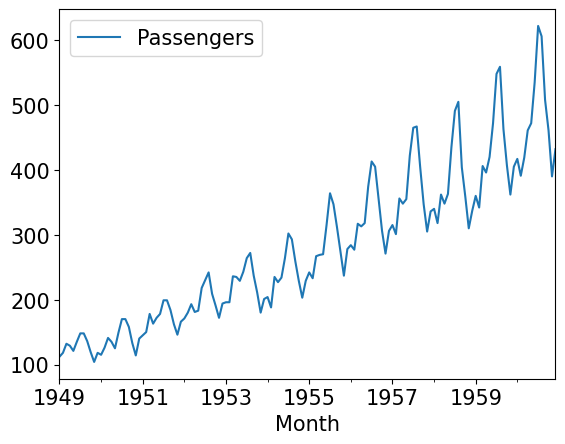

In [48]:
df = pd.read_csv("./dataset/AirPassengers.csv",index_col=0, parse_dates=True)
df.plot()
df

In [49]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')


# Create the Pandas
dataset = PandasDataset(df, target="Passengers")

backtest_dataset = dataset
prediction_length = 12 
num_samples = 24

In [50]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, num_samples)

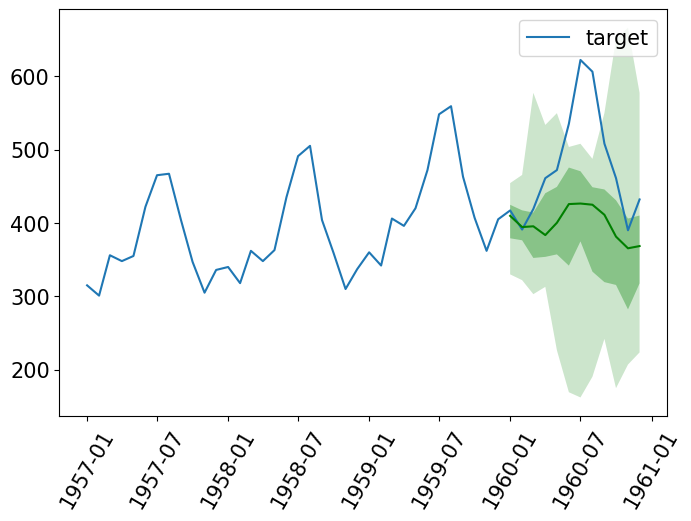

In [51]:
plt.figure(figsize=(20, 15))  # 设置绘图区域的大小为 20x15
date_formater = mdates.DateFormatter('%Y-%m')  
plt.rcParams.update({'font.size': 15})  # 更新字体大小为 15


# 遍历前 9 个时间序列，并绘制预测样本
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)  # 创建子图，3 行 3 列，当前是第 idx+1 个子图

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")  # 绘制实际数据
    forecast.plot(color='g')  # 绘制预测结果
    plt.xticks(rotation=60)  # x 轴标签旋转 60 度
    ax.xaxis.set_major_formatter(date_formater)  # 设置 x 轴主要刻度的日期格式

plt.gcf().tight_layout()  # 调整子图布局使其紧凑显示
plt.legend()  # 显示图例
plt.show()  # 展示绘制的图形